# Google drive mount
#### * google colab 사용 시, google drive 내 데이터를 사용하기 위한 절차입니다

In [ ]:
# google drive에 있는 데이터를 사용하기 위해 접근

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GPU Test
#### * 현재 코랩에서 GPU 사용이 가능한지 테스트하는 절차입니다

In [ ]:
# tensorflow를 import 하고, 현재 colab에서 gpu 구동이 되고 있는지 테스트 하는 코드
# Found GPU at: /device:GPU ~ 가 뜨면 성공

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# library import
#### * cv2, keras 등 이미지와 딥러닝 관련 모듈 사용을 위해 import 하는 절차입니다

In [ ]:
# 필요 library import
import pandas as pd
import numpy as np
import os
import cv2
import natsort
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import optimizers,initializers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Activation, concatenate, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Data load
#### * Model 학습에 사용할 데이터를 불러오는 절차입니다
#### * 이미지는 couple-male/couple-female/noncouple-male/noncouple-male 폴더로 나누어 저장했습니다

In [ ]:
# couple-male/couple-female/noncouple-male/noncouple-male 경로 저장 
couple_male_path = './drive/MyDrive/숨고/박동원님/01_Couple/male/' 
couple_female_path = './drive/MyDrive/숨고/박동원님/01_Couple/female'
noncouple_male_path = './drive/MyDrive/숨고/박동원님/02_Non_Couple/male'
noncouple_female_path = './drive/MyDrive/숨고/박동원님/02_Non_Couple/female'

# 각 남/여 image 파일의 경로와 couple 여부를 하나의 데이터프레임으로 만드는 과정
train_df = pd.DataFrame({"couple" : [1]*50})
train_df['male'] = [couple_male_path +"/"+i for i in natsort.natsorted(os.listdir(couple_male_path))]
train_df['female'] = [couple_female_path +"/"+i for i in natsort.natsorted(os.listdir(couple_female_path))]
train_df_noncouple = pd.DataFrame({"couple" : [0]*50})
train_df_noncouple['male'] = [noncouple_male_path +"/"+i for i in natsort.natsorted(os.listdir(noncouple_male_path))]
train_df_noncouple['female'] = [noncouple_female_path +"/"+i for i in natsort.natsorted(os.listdir(noncouple_female_path))]
train_df = pd.concat([train_df,train_df_noncouple],axis=0).reset_index(drop=True)
labels = train_df['couple'].values

train_df.head()

,couple,male,female
0,1,./drive/MyDrive/숨고/박동원님/01_Couple/male/0001.png,./drive/MyDrive/숨고/박동원님/01_Couple/female/0002.png
1,1,./drive/MyDrive/숨고/박동원님/01_Couple/male/0004.png,./drive/MyDrive/숨고/박동원님/01_Couple/female/0003.png
2,1,./drive/MyDrive/숨고/박동원님/01_Couple/male/0005.png,./drive/MyDrive/숨고/박동원님/01_Couple/female/0006.png
3,1,./drive/MyDrive/숨고/박동원님/01_Couple/male/0007.png,./drive/MyDrive/숨고/박동원님/01_Couple/female/0008.png
4,1,./drive/MyDrive/숨고/박동원님/01_Couple/male/0009.png,./drive/MyDrive/숨고/박동원님/01_Couple/female/0010.png


# Hyper-parameter setting
#### * 학습용 image 처리 및 딥러닝 학습 시, 조정할 hyperparameter 세팅

In [ ]:
## image 처리 관련
as_gray = False # 현재 image는 컬러이므로 as_gray = False로 저장
in_channel = 3 # rgb는 3채널 존재
img_rows, img_cols = 40, 40 # 사진 크기를 맞춰야함. 40 by 40로 임의 통일 

## 딥러닝 학습 관련
input_shape = (img_rows, img_cols, in_channel) # input shape은 40 x 40 x 3
batch_size = 8 # train batchsize(학습 셋이 적으므로 배치 수도 8로 설정)
epochs = 600 # epochs
learning_rate = 0.000001 # learning rate(현재 상황에서 학습률이 높으면 gradient가 발산하는것 확인)

# Data preprocessing
#### * 학습을 위한 이미지 데이터 처리 과정입니다
#### * 이미지를 행렬 형태로 불러오고, 사이즈를 통일합니다

In [ ]:
## image 처리 함수 생성
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels):
    images = []

    # skimage의 imread를 통해 경로별 image 를 불러온 후, cv2의 resize를 통해 이미지 사이즈 통일 
    for file_path in file_paths:
        images.append(cv2.resize(imread(file_path, as_gray = as_gray), (img_rows,img_cols)))

    images = np.asarray(images, dtype=np.float32) # 각 이미지 배열을 float 형태로 변환

    # 학습의 효율성을 위해 0~1 사이 값으로 normalize
    images = images / 255.0 

    # 딥러닝에 주입하기 위해 tesnor shape 조정
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)

    return images


# 남성 이미지 수집 및 처리
x_train_male = read_spectograms(train_df['male'].values, img_rows, img_cols, as_gray, in_channel)

# 여성 이미지 수집 및 처리
x_train_female = read_spectograms(train_df['female'].values, img_rows, img_cols, as_gray, in_channel)

# show image
#### * 학습을 위해 resizing 된 이미지를 커플/비커플 중 랜덤하게 1픽하여 찍어보는 과정입니다

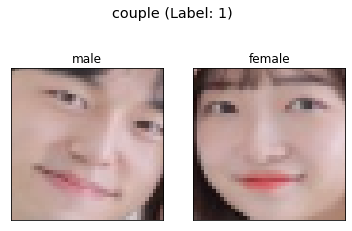

In [ ]:
# 커플/비커플 중 (남,여) 1짝을 픽하여 각각 저장
rn_couple = np.random.choice(train_df['couple'].index)
rn_label = train_df['couple'].values[rn_couple]
rn_male = x_train_male[rn_couple]
rn_female = x_train_female[rn_couple]

plt.figure()
plt.axis('off')

couple = ['Non-couple','couple']
plt.suptitle(f"{couple[rn_label]} (Label: {rn_label})", fontsize="x-large")

# 남자 사진 출력을 위한 코드 
plt.subplot(121)
curr_img = None
if as_gray:
  curr_img = np.reshape(rn_male, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_male, (img_rows, img_cols, in_channel))

plt.imshow(curr_img)
plt.title("male")
plt.xticks([])
plt.yticks([])

# 여자 사진 출력을 위한 코드 
plt.subplot(122)
if as_gray:
  curr_img = np.reshape(rn_female, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_female, (img_rows, img_cols, in_channel))

plt.imshow(curr_img)
plt.title("female")
plt.xticks([])
plt.yticks([])
plt.show()

# Split train and test set
#### * train set은 전체 데이터의 80% 비율로 추출하였습니다.
#### * ex) 전체 100커플 -> Train : 80커플, Test : 20커플

In [ ]:
## 남/여를 각 쌍으로 지정하여 분리해야 하므로 stack을 통해 우선 합쳐줌 
x_train_comp = np.stack((x_train_male, x_train_female), axis=4)

## train : test = 8:2로 분리(stratify의 경우 label의 비율을 유지한 채로 분리하도록 도와줌)
x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.2, random_state=202204122,stratify=labels)

## 위 stack으로 합친 것을 다시 남/여로 분리
x_train_male = x_train[:,:,:,:,0]
x_test_male = x_test[:,:,:,:,0]

x_train_female = x_train[:,:,:,:,1]
x_test_female = x_test[:,:,:,:,1]

# Training CNN Model
#### * 모델 학습을 위한 과정입니다.(모델은 CNN 모델 아키텍쳐를 응용 하였습니다)
#### * 우선 남/여 사진 한장씩을 넣어 커플 확률을 추출할 수 있는지에 대한 아키텍쳐 가능성을 확인한 것으로, 모델 튜닝은 충분히 하진 못한 상태입니다.(데이터가 충분해지면 layer를 더 쌓거나, batchnormalization 등 추가도 가능합니다)
#### * layer가 깊어지면 학습이 안되거나 오버피팅이 더 심해지는 것 확인했습니다 
#### * 각 layer별 입/출력 사이즈는 아래 summary()결과를 보시면 이해 가능합니다

In [ ]:
## cnn layer 생성
def create_convolution_layers(input_img):

    model = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=input_shape)(input_img)  # 3x3 사이즈 32채널인 conv.filter 추가
    model = BatchNormalization()(model) # BatchNormalization layer 추가
    model = LeakyReLU(alpha=0.1)(model) # LeakyReLU 활성 함수 추가
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model) # 2x2 사이즈 maxpooling layer 추가
    model = Dropout(0.25)(model) # 2x2 사이즈 maxpooling layer 추가

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model) # 3x3 사이즈 64채널인 conv.filter 추가
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.1)(model)
    model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
    model = Dropout(0.25)(model)

    return model 

male_input = Input(shape=input_shape) # 남성 input layer 정의
male_model = create_convolution_layers(male_input) # 남성 이미지의 conv. layer들을 거친 결과

female_input = Input(shape=input_shape) # 여성 input layer 정의
female_model = create_convolution_layers(female_input)  # 여성 이미지의 conv. layer들을 거친 결과

conv = concatenate([male_model, female_model])  # 두 결과를 이어붙임

conv = Flatten()(conv) # dense layer 주입을 위해 flat하는 과정

dense = Dense(512,kernel_initializer='he_normal')(conv) # dense layer
dense = BatchNormalization()(dense)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(1, activation='sigmoid')(dense) # sigmoid를 통한 확률 계산

model = Model(inputs=[male_input, female_input], outputs=[output]) # model에 데이터를 주입시킬 input layer 및 최종 output layer 정의

optimizer = optimizers.Adam(learning_rate=learning_rate) # optimizer 지정 

# model의 loss function, 사용할 optimizer, metirc 정의
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']) 

model.summary() # 모델 전체 아키텍처 출력

In [ ]:
best_weights_file="./drive/MyDrive/숨고/박동원님/weights.best.hdf5" # 학습 중 최상의 모델을 저장할 경로
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # 학습 중 validation acc 기준 최상의 모델을 저장하도록 checkpoint 설정

# model 학습 설정 및 학습 진행(주입할 input, label 데이터/batch_size/epochs/모델 저장/학습과정출력여부/학습 중 val_loss를 계산할 데이터비율, epoch마다 셔플 여부)
history = model.fit([x_train_male, x_train_female], y_train,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint] ,
        verbose=1,
        validation_split=0.1,
        shuffle=True)

# Model validation
#### * 만들어진 모델의 성능을 평가하기 위한 파트입니다.
#### * 위에서 분리한 Test set에 대해 55프로 정도의 정확도를 보이고 있습니다.
#### * 데이터가 매우 적은 상황임으로 loss graph를 보시면 validation loss가 global optima를 찾지 못하는 것을 보실 수 있습니다.
#### * train loss는 변동 폭이 심하나 지속적으로 줄어드는 패턴인 것으로, 모델이 학습은 가능함을 보여주고 있습니다.

1/1 [==============================] - 0s 29ms/step - loss: 0.7738 - accuracy: 0.5500

Accuracy: 0.5500


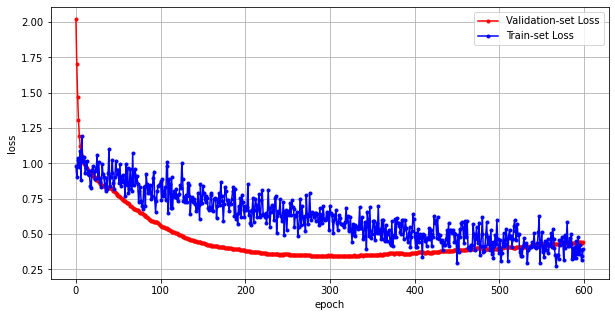

In [ ]:
model.load_weights(best_weights_file)

## 위에서 분리해둔 test set에 대하여 모델 정확도 반환
print('\nAccuracy: {:.4f}'.format(model.evaluate([x_test_male, x_test_female], y_test)[1])) 

y_vloss = history.history['val_loss'] # 학습 중 validation loss 저장
y_loss = history.history['loss'] # 학습 중 train loss 저장
x_len = np.arange(len(y_loss)) # 전체 epoch 길이 저장(현재 500)

plt.figure(figsize=(10,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss") # validation loss에 대한 그래프 출력
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss") # train loss에 대한 그래프 출력
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Classification for real data(Test)
#### * 실제 사진으로 커플 확률을 도출하는 과정입니다
#### * 서비스를 하게 된다면 아래와 같은 과정을 거치게 될 것으로 보입니다.
#### * 학습 용도가 아니므로 resizing 하지 않은 이미지를 그대로 출력하였습니다.

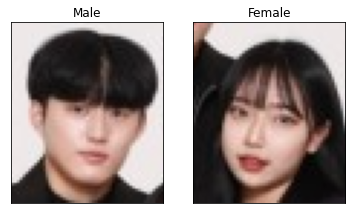

커플 확률 : 76 %입니다.


In [ ]:
## 가져올 남, 여 이미지 하나씩 선정(실제 커플인 경우)
real_male_path = './drive/MyDrive/숨고/박동원님/01_Couple/male/0015.png'
real_female_path = './drive/MyDrive/숨고/박동원님/01_Couple/female/0016.png'

## 모델 예측을 위한 이미지 전처리 과정 및 모델 예측 결과 저장
img_rows = 40
img_cols = 40
channel = 3
as_gray = False
real_male = read_spectograms([real_male_path], img_rows, img_cols, as_gray, channel) # 이미지 전처리 과정(위에서 만들어둔 read_spectograms 함수 이용)
real_female = read_spectograms([real_female_path], img_rows, img_cols, as_gray, channel) # 이미지 전처리 과정(위에서 만들어둔 read_spectograms 함수 이용)
prob = model.predict([real_male,real_female]) # 모델 예측


## 불러온 이미지 그대로 출력
# 남자 사진 출력을 위한 코드
plt.subplot(121)
curr_img = imread(real_male_path, as_gray = False) # 이미지 불러온 후 수치 변환
plt.imshow(curr_img) # 이미지 출력
plt.title("Male")
plt.xticks([])
plt.yticks([])

# 여자 사진 출력을 위한 코드 
plt.subplot(122)
curr_img = imread(real_female_path, as_gray = False) # 이미지 불러온 후 수치 변환
plt.imshow(curr_img) # 이미지 출력
plt.title("Female")
plt.xticks([])
plt.yticks([])
plt.show() # plt.show() 이후 아래 print를 해줘야 순서상 이미지 출력 후 print 문자 출력이 됩니다.

print("커플 확률 : %d"%int(prob*100), "%입니다.")